# Import Libraries

In [ ]:
## install pyportfolio (Min-Var Portfolio Allocation)
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 1.7 MB/s 
     |████████████████████████████████| 2.8 MB 35.9 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-jekf94b5
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-jekf94b5
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-b2urlzj5/pyfolio_70624da58c7e408d9e05739002d5bc20
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-b2urlzj5/pyfolio_70624da58c7e408d9e05739002d5bc20
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-b2urlzj5/elegantrl_ed1235bd045c4c159ac673823d9664bd
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-b2urlzj5/elegantrl_ed1235bd045c4c159ac673823d9664bd
     |████████████████████████████████| 73 kB 1.6 MB/s 
     |████████████████████████████████| 174 kB 45.6 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 30.8 MB/s 
     |██████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
matplotlib.use('Agg')
%matplotlib inline
import datetime

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading_cashpenalty import StockTradingEnvCashpenalty
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



# Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# **Functions**

## Stock Trading Cash Penalty Environment

In [ ]:
import random
import time
from copy import deepcopy

import gym
import matplotlib
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3.common import utils
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

matplotlib.use("Agg")

class StockTradingEnvCashpenalty(gym.Env):
    """
    A stock trading environment for OpenAI gym
    This environment penalizes the model for not maintaining a reserve of cash.
    This enables the model to manage cash reserves in addition to performing trading procedures.
    Reward at any step is given as follows
        r_i = (sum(cash, asset_value) - initial_cash - max(0, sum(cash, asset_value)*cash_penalty_proportion-cash))/(days_elapsed)
        This reward function takes into account a liquidity requirement, as well as long-term accrued rewards.
    Parameters:
    state space: {start_cash, [shares_i for in in assets], [[indicator_j for j in indicators] for i in assets]]}
        df (pandas.DataFrame): Dataframe containing data
        buy_cost_pct (float): cost for buying shares
        sell_cost_pct (float): cost for selling shares
        hmax (int, array): maximum cash to be traded in each trade per asset. If an array is provided, then each index correspond to each asset
        discrete_actions (bool): option to choose whether perform dicretization on actions space or not
        shares_increment (int): multiples number of shares can be bought in each trade. Only applicable if discrete_actions=True
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. It could be OHLC columns or any other variables such as technical indicators and turbulence index
        cash_penalty_proportion (int, float): Penalty to apply if the algorithm runs out of cash
        patient (bool): option to choose whether end the cycle when we're running out of cash or just don't buy anything until we got additional cash
    action space: [<n_assets>,] in range {-1, 1}   
    """
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        buy_cost_pct=3e-3,
        sell_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        discrete_actions=False,
        shares_increment=1,
        turbulence_threshold=None,
        print_verbosity=10,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        cache_indicator_data=True,
        cash_penalty_proportion=0.1,
        random_start=True,
        patient=False,
        currency="$",
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.random_start = random_start
        self.discrete_actions = discrete_actions
        self.patient = patient
        self.currency = currency
        self.df = self.df.set_index(date_col_name)
        self.shares_increment = shares_increment
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.print_verbosity = print_verbosity
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.turbulence_threshold = turbulence_threshold
        self.daily_information_cols = daily_information_cols
        self.state_space = (1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols))
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_space,))
        self.turbulence = 0
        self.episode = -1  # initialize so we can call reset
        self.episode_history = []
        self.printed_header = False
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        self.cash_penalty_proportion = cash_penalty_proportion
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [self.get_date_vector(i) for i, _ in enumerate(self.dates)]
            print("data cached!")

    def seed(self, seed=None):
        if seed is None:
            seed = int(round(time.time() * 1000))
        random.seed(seed)

    @property
    def current_step(self):
        return self.date_index - self.starting_point

    @property
    def cash_on_hand(self):
        # amount of cash held at current timestep
        return self.state_memory[-1][0]

    @property
    def holdings(self):
        # Quantity of shares held at current timestep
        return self.state_memory[-1][1 : len(self.assets) + 1]

    @property
    def closings(self):
        return np.array(self.get_date_vector(self.date_index, cols=["close"]))

    def reset(self):
        self.seed()
        self.sum_trades = 0
        if self.random_start:
            starting_point = random.choice(range(int(len(self.dates) * 0.5)))
            self.starting_point = starting_point
        else:
            self.starting_point = 0
        self.date_index = self.starting_point
        self.turbulence = 0
        self.episode += 1
        self.actions_memory = []
        self.transaction_memory = []
        self.state_memory = []
        self.account_information = {"cash": [],
                                    "asset_value": [],
                                    "total_assets": [],
                                    "reward": [],}
        init_state = np.array([self.initial_amount] + [0] * len(self.assets) + self.get_date_vector(self.date_index))
        self.state_memory.append(init_state)
        return init_state

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[[date]]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v

    def return_terminal(self, reason="Last Date", reward=0):
        state = self.state_memory[-1]
        self.log_step(reason=reason, terminal_reward=reward)
        # add outputs to logger interface
        self.logger = utils.configure_logger()
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        self.logger.record("environment/GainLoss_pct", (gl_pct - 1) * 100)
        self.logger.record("environment/total_assets", int(self.account_information["total_assets"][-1]),)
        reward_pct = self.account_information["total_assets"][-1] / self.initial_amount
        self.logger.record("environment/total_reward_pct", (reward_pct - 1) * 100)
        self.logger.record("environment/total_trades", self.sum_trades)
        self.logger.record("environment/avg_daily_trades", self.sum_trades / (self.current_step),)
        self.logger.record("environment/avg_daily_trades_per_asset", self.sum_trades / (self.current_step) / len(self.assets),)
        self.logger.record("environment/completed_steps", self.current_step)
        self.logger.record("environment/sum_rewards", np.sum(self.account_information["reward"]))
        self.logger.record("environment/cash_proportion", self.account_information["cash"][-1] / self.account_information["total_assets"][-1],)
        return state, reward, True, {}

    def log_step(self, reason, terminal_reward=None):
        if terminal_reward is None:
            terminal_reward = self.account_information["reward"][-1]
        cash_pct = (self.account_information["cash"][-1] / self.account_information["total_assets"][-1])
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        rec = [self.episode,
               self.date_index - self.starting_point,
               reason,
               f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['cash'][-1]))}",
               f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['total_assets'][-1]))}",
               f"{terminal_reward*100:0.5f}%",
               f"{(gl_pct - 1)*100:0.5f}%",
               f"{cash_pct*100:0.2f}%",]
        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def log_header(self):
        if self.printed_header is False:
            self.template = "{0:4}|{1:4}|{2:15}|{3:15}|{4:15}|{5:10}|{6:10}|{7:10}"  # column widths: 8, 10, 15, 7, 10
            print(self.template.format("EPISODE",
                                       "STEPS",
                                       "TERMINAL_REASON",
                                       "CASH",
                                       "TOT_ASSETS",
                                       "TERMINAL_REWARD_unsc",
                                       "GAINLOSS_PCT",
                                       "CASH_PROPORTION",))
            self.printed_header = True

    def get_reward(self):
        if self.current_step == 0:
            return 0
        else:
            assets = self.account_information["total_assets"][-1]
            cash = self.account_information["cash"][-1]
            cash_penalty = max(0, (assets * self.cash_penalty_proportion - cash))
            assets -= cash_penalty
            reward = (assets / self.initial_amount) - 1
            reward /= self.current_step
            return reward

    def get_transactions(self, actions):
        """
        This function takes in a raw 'action' from the model and makes it into realistic transactions
        This function includes logic for discretizing
        It also includes turbulence logic
        """
        # record actions of the model
        self.actions_memory.append(actions)
        # multiply actions by the hmax value
        actions = actions * self.hmax
        # do nothing for shares with zero value
        actions = np.where(self.closings > 0, actions, 0)
        # discretize optionally
        if self.discrete_actions:
            # convert into integer because we can't buy fraction of shares
            actions = actions // self.closings
            actions = actions.astype(int)
            # round down actions to the nearest multiplies of shares_increment
            actions = np.where(actions >= 0,
                               (actions // self.shares_increment) * self.shares_increment,
                               ((actions + self.shares_increment) // self.shares_increment) * self.shares_increment,)
        else:
            actions = actions / self.closings
        # can't sell more than we have
        actions = np.maximum(actions, -np.array(self.holdings))
        # deal with turbulence
        if self.turbulence_threshold is not None:
            # if turbulence goes over threshold, just clear out all positions
            if self.turbulence >= self.turbulence_threshold:
                actions = -(np.array(self.holdings))
                self.log_step(reason="TURBULENCE")
        return actions

    def step(self, actions):
        # let's just log what we're doing in terms of max actions at each step
        self.sum_trades += np.sum(np.abs(actions))
        self.log_header()
        # print if it's time
        if (self.current_step + 1) % self.print_verbosity == 0:
            self.log_step(reason="update")
        # if we're at the end
        if self.date_index == len(self.dates) - 1:
            # if we hit the end, set reward to total gains (or losses)
            return self.return_terminal(reward=self.get_reward())
        else:
            # compute value of cash + assets
            begin_cash = self.cash_on_hand
            assert min(self.holdings) >= 0
            asset_value = np.dot(self.holdings, self.closings)
            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)
            # compute reward once we've computed the value of things
            reward = self.get_reward()
            self.account_information["reward"].append(reward)
            # now, let's get down to business at hand
            transactions = self.get_transactions(actions)
            # compute our proceeds from sells, and add to cash
            sells = -np.clip(transactions, -np.inf, 0)
            proceeds = np.dot(sells, self.closings)
            costs = proceeds * self.sell_cost_pct
            coh = begin_cash + proceeds
            # compute the cost of our buys
            buys = np.clip(transactions, 0, np.inf)
            spend = np.dot(buys, self.closings)
            costs += spend * self.buy_cost_pct
            # if we run out of cash...
            if (spend + costs) > coh:
                if self.patient:
                    # ... just don't buy anything until we got additional cash
                    self.log_step(reason="CASH SHORTAGE")
                    transactions = np.where(transactions > 0, 0, transactions)
                    spend = 0
                    costs = 0
                else:
                    # ... end the cycle and penalize
                    return self.return_terminal(reason="CASH SHORTAGE", reward=self.get_reward())
            
            self.transaction_memory.append(transactions)  # capture what the model's could do
            
            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh
            
            # update our holdings
            coh = coh - spend - costs
            holdings_updated = self.holdings + transactions
            self.date_index += 1
            if self.turbulence_threshold is not None:
                self.turbulence = self.get_date_vector(self.date_index, cols=["turbulence"])[0]
            
            # update State
            state = ([coh] + list(holdings_updated) + self.get_date_vector(self.date_index))
            self.state_memory.append(state)
            return state, reward, False, {}

    def get_sb_env(self):
        def get_self():
            return deepcopy(self)
        e = DummyVecEnv([get_self])
        obs = e.reset()
        return e, obs

    def get_multiproc_env(self, n=10):
        def get_self():
            return deepcopy(self)
        e = SubprocVecEnv([get_self for _ in range(n)], start_method="fork")
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        if self.current_step == 0:
            return None
        else:
            self.account_information["date"] = self.dates[-len(self.account_information["cash"]) :]
            return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        if self.current_step == 0:
            return None
        else:
            return pd.DataFrame({"date": self.dates[-len(self.account_information["cash"]) :],
                                 "actions": self.actions_memory,
                                 "transactions": self.transaction_memory,})

## Stable Baselines 3 DRL Models & Agents

In [ ]:
import time

from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import (NormalActionNoise, OrnsteinUhlenbeckActionNoise,)
from stable_baselines3.common.vec_env import DummyVecEnv

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {"normal": NormalActionNoise, "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,}

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard
    """

    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

class DRLAgent:
    """
    Provides implementations for DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(self,
                  model_name,
                  policy="MlpPolicy",
                  policy_kwargs=None,
                  model_kwargs=None,
                  verbose=1,
                  seed=None,
                 ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]
        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(model_kwargs)
        model = MODELS[model_name](policy=policy,
                                   env=self.env,
                                   tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
                                   verbose=verbose,
                                   policy_kwargs=policy_kwargs,
                                   seed=seed,
                                   **model_kwargs,)
        return model

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps,
                            tb_log_name=tb_log_name,
                            callback=TensorboardCallback(),)
        return model

    @staticmethod
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        """
        Make a prediction
        """
        account_memory = []
        actions_memory = []
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs)
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")
        # test on the testing env
        state = environment.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(environment.initial_total_asset)
        done = False
        while not done:
            action = model.predict(state)[0]
            state, reward, done, _ = environment.step(action)
            total_asset = (environment.amount + (environment.price_ary[environment.day] * environment.stocks).sum())
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)
        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets

# Download Data

In [ ]:
# DOW_30_TICKER
# NAS_100_TICKER
# SP_500_TICKER 

In [ ]:
# index constituents
print(config.NAS_100_TICKER)

['AMGN', 'AAPL', 'AMAT', 'INTC', 'PCAR', 'PAYX', 'MSFT', 'ADBE', 'CSCO', 'XLNX', 'QCOM', 'COST', 'SBUX', 'FISV', 'CTXS', 'INTU', 'AMZN', 'EBAY', 'BIIB', 'CHKP', 'GILD', 'NLOK', 'CMCSA', 'FAST', 'ADSK', 'CTSH', 'NVDA', 'GOOGL', 'ISRG', 'VRTX', 'HSIC', 'BIDU', 'ATVI', 'ADP', 'ROST', 'ORLY', 'CERN', 'BKNG', 'MYL', 'MU', 'DLTR', 'ALXN', 'SIRI', 'MNST', 'AVGO', 'TXN', 'MDLZ', 'FB', 'ADI', 'WDC', 'REGN', 'LBTYK', 'VRSK', 'NFLX', 'TSLA', 'CHTR', 'MAR', 'ILMN', 'LRCX', 'EA', 'AAL', 'WBA', 'KHC', 'BMRN', 'JD', 'SWKS', 'INCY', 'PYPL', 'CDW', 'FOXA', 'MXIM', 'TMUS', 'EXPE', 'TCOM', 'ULTA', 'CSX', 'NTES', 'MCHP', 'CTAS', 'KLAC', 'HAS', 'JBHT', 'IDXX', 'WYNN', 'MELI', 'ALGN', 'CDNS', 'WDAY', 'SNPS', 'ASML', 'TTWO', 'PEP', 'NXPI', 'XEL', 'AMD', 'NTAP', 'VRSN', 'LULU', 'WLTW', 'UAL']


In [ ]:
df = YahooDownloader(start_date = '2000-01-01',
                     end_date = '2021-11-01',
                     ticker_list = config.NAS_100_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Preprocess Data

In [ ]:
# technical indicators list
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
  # add technical indicators, vix and turbulence
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (5492, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
processed

date        open        high  ...  close_60_sma        vix  turbulence
0       2000-01-03    0.936384    1.004464  ...      0.856887  24.209999    0.000000
1       2000-01-03   16.812500   16.875000  ...     16.274672  24.209999    0.000000
2       2000-01-03   46.750000   46.937500  ...     29.667679  24.209999    0.000000
3       2000-01-03   42.428928   42.775894  ...     25.976387  24.209999    0.000000
4       2000-01-03    8.500000    8.656250  ...      8.052906  24.209999    0.000000
...            ...         ...         ...  ...           ...        ...         ...
362467  2021-10-28  181.190002  183.830002  ...    189.037501  16.530001  198.476881
362468  2021-10-28   47.080002   47.349998  ...     48.092658  16.530001  198.476881
362469  2021-10-28   55.860001   57.340000  ...     59.233333  16.530001  198.476881
362470  2021-10-28   63.080002   64.589996  ...     66.046343  16.530001  198.476881
362471  2021-10-28  184.289993  185.720001  ...    155.706698  16.530001  198.476881

[362472 rows x 18 columns]

In [ ]:
# data wrangling
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full

date   tic        open  ...  close_60_sma        vix  turbulence
0       2000-01-03  AAPL    0.936384  ...      0.856887  24.209999    0.000000
1       2000-01-03  ADBE   16.812500  ...     16.274672  24.209999    0.000000
2       2000-01-03   ADI   46.750000  ...     29.667679  24.209999    0.000000
3       2000-01-03   ADP   42.428928  ...     25.976387  24.209999    0.000000
4       2000-01-03  ADSK    8.500000  ...      8.052906  24.209999    0.000000
...            ...   ...         ...  ...           ...        ...         ...
526015  2021-10-28  VRTX  181.190002  ...    189.037501  16.530001  198.476881
526016  2021-10-28   WBA   47.080002  ...     48.092658  16.530001  198.476881
526017  2021-10-28   WDC   55.860001  ...     59.233333  16.530001  198.476881
526018  2021-10-28   XEL   63.080002  ...     66.046343  16.530001  198.476881
526019  2021-10-28  XLNX  184.289993  ...    155.706698  16.530001  198.476881

[362472 rows x 18 columns]

In [ ]:
# set turbulance threshold
data_risk_indicator = processed_full[(processed_full.date<'2020-01-01') & (processed_full.date>='2000-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

# Multiple Stock Trading

## Design Environment

In [ ]:
train = data_split(processed_full, '2000-01-01','2020-01-01')
trade = data_split(processed_full, '2020-01-01','2021-10-01')
print(len(train))
print(len(trade))

332046
29106


In [ ]:
e_train_gym = StockTradingEnvCashpenalty(df = train,
                                         initial_amount = 1000000,
                                         hmax = 100, 
                                         turbulence_threshold = None, 
                                         currency='$',
                                         buy_cost_pct=0.001,
                                         sell_cost_pct=0.001,
                                         cash_penalty_proportion=0.05,
                                         cache_indicator_data=True,
                                         daily_information_cols = config.TECHNICAL_INDICATORS_LIST, 
                                         print_verbosity = 500, 
                                         random_start = True,
                                         patient=True)

e_trade_gym = StockTradingEnvCashpenalty(df = trade,
                                         initial_amount = 1000000,
                                         hmax = 100, 
                                         turbulence_threshold = None, 
                                         currency='$',
                                         buy_cost_pct=0.001,
                                         sell_cost_pct=0.001,
                                         cash_penalty_proportion=0.05,
                                         cache_indicator_data=True,
                                         daily_information_cols = config.TECHNICAL_INDICATORS_LIST, 
                                         print_verbosity = 500, 
                                         random_start = False,
                                         patient=True )

caching data
data cached!
caching data
data cached!


In [ ]:
env_train, _ = e_train_gym.get_sb_env()
env_trade, _ = e_trade_gym.get_sb_env()

## Implement DRL Algorithms

In [ ]:
# Model 1: A2C (Cash Penalty Env)
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
 model_a2c.learn(total_timesteps = 25000, 
                 eval_env = env_trade, 
                 eval_freq = 500,
                 log_interval = 1, 
                 tb_log_name = 'a2c',
                 n_eval_episodes = 1)
model_a2c.save("a2c.model")

Logging to tensorboard_log/a2c/a2c_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
--------------------------
| time/              |   |
|    fps             | 1 |
|    iterations      | 1 |
|    time_elapsed    | 4 |
|    total_timesteps | 5 |
--------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 2        |
|    time_elapsed       | 6        |
|    total_timesteps    | 10       |
| train/                |          |
|    entropy_loss       | -93.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1        |
|    policy_loss        | 2.47     |
|    std                | 1        |
|    value_loss         | 0.000816 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1      

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1        |
|    iterations         | 4691     |
|    time_elapsed       | 15220    |
|    total_timesteps    | 23455    |
| train/                |          |
|    entropy_loss       | -294     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4690     |
|    policy_loss        | -0.0918  |
|    std                | 20.7     |
|    value_loss         | 1.14e-07 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1         |
|    iterations         | 4692      |
|    time_elapsed       | 15221     |
|    total_timesteps    | 23460     |
| train/                |           |
|    entropy_loss       | -294      |
|    explained_variance | -1.19e-07 |
|    learning_

In [ ]:
# Model 2: PPO (Cash Penalty Env)
agent = DRLAgent(env = env_train)
PPO_PARAMS = {"n_steps": 2048,
              "ent_coef": 0.01,
              "learning_rate": 0.00025,
              "batch_size": 64}
model_ppo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device


In [ ]:
model_ppo.learn(total_timesteps = 25000, 
                eval_env = env_trade, 
                eval_freq = 500,
                log_interval = 1, 
                tb_log_name = 'ppo',
                n_eval_episodes = 1)
model_ppo.save("ppo.model")

Logging to tensorboard_log/ppo/ppo_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 499|update         |$921,670       |$1,001,990     |0.00040%  |0.19900%  |91.98%    


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 440|Last Date      |$990,910       |$1,001,835     |0.00042%  |0.18346%  |98.91%    
Eval num_timesteps=500, episode_reward=0.00 +/- 0.00
Episode length: 441.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 441      |
|    mean_reward     | 0.00145  |
| time/              |          |
|    total_timesteps | 500      |
---------------------------------
New best mean reward!
   1| 999|update         |$879,887       |$1,015,816     |0.00158%  |1.58161%  |86.62%    
   3| 440|Last Date      |$990,910       |$1,001,835     |0.00042%  |0.18346%  |98.91%    
Eval num_timesteps=1000, episode_reward=0.00 +/- 0.00
Episode length: 441.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 441      |
|    mean_reward     | 0.00145  |
| time/              |          |
|    total_tim

In [ ]:
# Model 3: DDPG (Cash Penalty Env)
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
model_ddpg.learn(total_timesteps = 25000, 
                 eval_env = env_trade, 
                 eval_freq = 500,
                 log_interval = 1, 
                 tb_log_name = 'ddpg',
                 n_eval_episodes = 1)
model_ddpg.save("ddpg.model")

Logging to tensorboard_log/ddpg/ddpg_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 381|CASH SHORTAGE  |$78            |$748,315       |-0.07586% |-25.16854%|0.01%     
   1| 383|CASH SHORTAGE  |$686           |$728,345       |-0.08026% |-27.16552%|0.09%     
   1| 386|CASH SHORTAGE  |$177           |$757,959       |-0.07248% |-24.20408%|0.02%     
   1| 388|CASH SHORTAGE  |$747           |$714,996       |-0.08248% |-28.50036%|0.10%     
   1| 390|CASH SHORTAGE  |$1,142         |$718,345       |-0.08114% |-28.16551%|0.16%     
   1| 393|CASH SHORTAGE  |$333           |$741,906       |-0.07503% |-25.80943%|0.04%     
   1| 395|CASH SHORTAGE  |$519           |$721,274       |-0.07956% |-27.87264%|0.07%     
   1| 397|CASH SHORTAGE  |$615           |$771,566       |-0.06710% |-22.84337%|0.08%     
   1| 399|CASH SHORTAGE  |$710           |$806,675       |-0.05838% |-19.33250%|0.09%     
   1| 401|CASH SHORTAGE  |$806

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
  85| 413|CASH SHORTAGE  |$1,402         |$1,327,796     |0.06363%  |32.77960% |0.11%     
  85| 414|CASH SHORTAGE  |$1,402         |$1,328,594     |0.06366%  |32.85936% |0.11%     
  85| 415|CASH SHORTAGE  |$1,402         |$1,332,575     |0.06442%  |33.25746% |0.11%     
  85| 416|CASH SHORTAGE  |$1,402         |$1,320,844     |0.06159%  |32.08437% |0.11%     
  85| 417|CASH SHORTAGE  |$1,402         |$1,339,339     |0.06565%  |33.93392% |0.10%     
  85| 418|CASH SHORTAGE  |$1,402         |$1,343,299     |0.06640%  |34.32993% |0.10%     
  85| 419|CASH SHORTAGE  |$1,402         |$1,340,870     |0.06569%  |34.08698% |0.10%     
  85| 420|CASH SHORTAGE  |$1,402         |$1,339,633     |0.06525%  |33.96326% |0.10%     
  85| 421|CASH SHORTAGE  |$1,402         |$1,344,047     |0.06609%  |34.40470% |0.10%     
  85| 422|CASH SHORTAGE  |$1,402         |$1,344,570     |0.06605%  |34.45705% |0.10%     
  85| 423|CASH SHORTAGE  |$1,402       

In [ ]:
# Model 4: TD3 (Cash Penalty Env)
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 64, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}
model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
model_td3.learn(total_timesteps = 25000, 
                eval_env = env_trade, 
                eval_freq = 500,
                log_interval = 1, 
                tb_log_name = 'td3',
                n_eval_episodes = 1)
model_td3.save("td3.model")

Logging to tensorboard_log/td3/td3_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
   3|1938|CASH SHORTAGE  |$1,884         |$2,710,080     |0.08134%  |171.00798%|0.07%     
   3|1939|CASH SHORTAGE  |$1,884         |$2,728,188     |0.08219%  |172.81878%|0.07%     
   3|1940|CASH SHORTAGE  |$1,884         |$2,742,113     |0.08283%  |174.21126%|0.07%     
   3|1941|CASH SHORTAGE  |$1,884         |$2,764,193     |0.08387%  |176.41930%|0.07%     
   3|1942|CASH SHORTAGE  |$1,884         |$2,741,470     |0.08271%  |174.14697%|0.07%     
   3|1943|CASH SHORTAGE  |$1,884         |$2,768,706     |0.08400%  |176.87063%|0.07%     
   3|1944|CASH SHORTAGE  |$1,884         |$2,742,940     |0.08270%  |174.29403%|0.07%     
   3|1945|CASH SHORTAGE  |$1,884         |$2,698,113     |0.08047%  |169.81127%|0.07%     
   3|1946|CASH SHORTAGE  |$1,884         |$2,695,195     |0.08028%  |169.51949%|0.07%     
   3|1947|CASH SHORTAGE  |$1,884         |$2,731,223     |0.08200%  |173.12231%|0.07%     
   3|1948|CASH SHORTAGE  |$1,884       

In [ ]:
# Model 5: SAC (Cash Penalty Env)
agent = DRLAgent(env = env_trade)
SAC_PARAMS = {"batch_size": 64,
              "buffer_size": 1000000,
              "learning_rate": 0.0001,
              "learning_starts": 100,
              "ent_coef": "auto_0.1"}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
model_sac.learn(total_timesteps = 25000, 
                eval_env = env_trade, 
                eval_freq = 500,
                log_interval = 1, 
                tb_log_name = 'sac',
                n_eval_episodes = 1)
model_sac.save("sac.model")

Logging to tensorboard_log/sac/sac_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 440|Last Date      |$165,029       |$1,123,426     |0.02805%  |12.34264% |14.69%    
---------------------------------
| time/              |          |
|    episodes        | 1        |
|    fps             | 2        |
|    time_elapsed    | 190      |
|    total_timesteps | 441      |
| train/             |          |
|    actor_loss      | 4.12e+03 |
|    critic_loss     | 55.1     |
|    ent_coef        | 0.103    |
|    ent_coef_loss   | 2.99e+03 |
|    learning_rate   | 0.0001   |
|    n_updates       | 340      |
---------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
  17|1726|CASH SHORTAGE  |$2,947         |$2,397,382     |0.07419%  |139.73820%|0.12%     
  17|1727|CASH SHORTAGE  |$3,164         |$2,397,761     |0.07418%  |139.77613%|0.13%     
  17|1728|CASH SHORTAGE  |$3,362         |$2,385,317     |0.07346%  |138.53174%|0.14%     
  17|1729|CASH SHORTAGE  |$3,561         |$2,372,209     |0.07271%  |137.22087%|0.15%     
  17|1730|CASH SHORTAGE  |$3,757         |$2,363,463     |0.07220%  |136.34630%|0.16%     
  17|1732|CASH SHORTAGE  |$449           |$2,383,446     |0.07302%  |138.34464%|0.02%     
  17|1733|CASH SHORTAGE  |$649           |$2,377,963     |0.07269%  |137.79632%|0.03%     
  17|1734|CASH SHORTAGE  |$848           |$2,350,491     |0.07115%  |135.04910%|0.04%     
  17|1735|CASH SHORTAGE  |$1,048         |$2,346,050     |0.07088%  |134.60498%|0.04%     
  17|1736|CASH SHORTAGE  |$1,230         |$2,357,497     |0.07148%  |135.74966%|0.05%     
  17|1737|CASH SHORTAGE  |$1,394       

# Trade

In [ ]:
# Model 1: A2C (Cash Penalty Env)
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=model_a2c,
                                                               environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 440|Last Date      |$887,136       |$1,027,519     |0.00625%  |2.75190%  |86.34%    
hit end!


In [ ]:
# Model 2: PPO (Cash Penalty Env)
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=model_ppo,
                                                               environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 440|Last Date      |$903,462       |$1,031,150     |0.00708%  |3.11498%  |87.62%    
hit end!


In [ ]:
# Model 3: DDPG (Cash Penalty Env)
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(model=model_ddpg,
                                                                 environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 344|CASH SHORTAGE  |$1,402         |$1,253,923     |0.05600%  |25.39234% |0.11%     
   1| 345|CASH SHORTAGE  |$1,402         |$1,246,150     |0.05369%  |24.61505% |0.11%     
   1| 346|CASH SHORTAGE  |$1,402         |$1,236,322     |0.05084%  |23.63223% |0.11%     
   1| 347|CASH SHORTAGE  |$1,402         |$1,241,548     |0.05212%  |24.15482% |0.11%     
   1| 348|CASH SHORTAGE  |$1,402         |$1,260,464     |0.05714%  |26.04636% |0.11%     
   1| 349|CASH SHORTAGE  |$1,402         |$1,253,374     |0.05505%  |25.33739% |0.11%     
   1| 350|CASH SHORTAGE  |$1,402         |$1,269,173     |0.05918%  |26.91727% |0.11%     
   1| 351|CASH SHORTAGE  |$1,402         |$1,270,538     |0.05938%  |27.05377% |0.11%     
   1| 352|CASH SHORTAGE  |$1,402         |$1,272,950     |0.05986%  |27.29496% |0.11%     
   1| 353|CASH SHORTAGE  |$1,402         |$1,270,940     |0.05915%  |

In [ ]:
# Model 4: TD3 (Cash Penalty Env)
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(model=model_td3,
                                                               environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 305|CASH SHORTAGE  |$1,093         |$1,228,955     |0.05528%  |22.89546% |0.09%     
   1| 306|CASH SHORTAGE  |$1,293         |$1,248,709     |0.06130%  |24.87091% |0.10%     
   1| 307|CASH SHORTAGE  |$1,493         |$1,233,333     |0.05640%  |23.33335% |0.12%     
   1| 308|CASH SHORTAGE  |$1,693         |$1,224,619     |0.05360%  |22.46190% |0.14%     
   1| 309|CASH SHORTAGE  |$1,893         |$1,228,541     |0.05469%  |22.85407% |0.15%     
   1| 310|CASH SHORTAGE  |$2,093         |$1,270,251     |0.06737%  |27.02515% |0.16%     
   1| 311|CASH SHORTAGE  |$2,293         |$1,263,886     |0.06527%  |26.38862% |0.18%     
   1| 312|CASH SHORTAGE  |$2,493         |$1,255,470     |0.06256%  |25.54696% |0.20%     
   1| 313|CASH SHORTAGE  |$2,693         |$1,275,823     |0.06860%  |27.58234% |0.21%     
   1| 314|CASH SHORTAGE  |$2,893         |$1,306,934     |0.07786%  |

In [ ]:
# Model 5: SAC (Cash Penalty Env)
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(model=model_sac,
                                                               environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 261|CASH SHORTAGE  |$1,243         |$1,244,578     |0.07034%  |24.45775% |0.10%     
   1| 263|CASH SHORTAGE  |$347           |$1,245,614     |0.06984%  |24.56141% |0.03%     
   1| 264|CASH SHORTAGE  |$2,041         |$1,248,789     |0.07136%  |24.87889% |0.16%     
   1| 266|CASH SHORTAGE  |$452           |$1,242,299     |0.06791%  |24.22995% |0.04%     
   1| 267|CASH SHORTAGE  |$1,951         |$1,247,367     |0.07002%  |24.73670% |0.16%     
   1| 269|CASH SHORTAGE  |$1,045         |$1,213,502     |0.05720%  |21.35021% |0.09%     
   1| 271|CASH SHORTAGE  |$197           |$1,198,055     |0.05105%  |19.80554% |0.02%     
   1| 272|CASH SHORTAGE  |$1,697         |$1,218,551     |0.05857%  |21.85505% |0.14%     
   1| 274|CASH SHORTAGE  |$532           |$1,228,061     |0.06102%  |22.80610% |0.04%     
   1| 275|CASH SHORTAGE  |$2,201         |$1,238,070     |0.06486%  |

# Back Test Stats

In [ ]:
# Model 1: A2C (Cash Penalty Env)
print("==========A2C Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_a2c, 
                                value_col_name = 'total_assets')

==========A2C Backtest Results==========
Annual return          0.015669
Cumulative returns     0.027519
Annual volatility      0.016542
Sharpe ratio           0.950324
Calmar ratio           1.555171
Stability              0.934646
Max drawdown          -0.010076
Omega ratio            1.172304
Sortino ratio          1.338961
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.112435
Daily value at risk   -0.002022
dtype: float64


In [ ]:
# Model 2: PPO (Cash Penalty Env)
print("==========PPO Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_ppo, 
                                value_col_name = 'total_assets')

==========PPO Backtest Results==========
Annual return          0.017723
Cumulative returns     0.031150
Annual volatility      0.016440
Sharpe ratio           1.079301
Calmar ratio           1.819700
Stability              0.949054
Max drawdown          -0.009740
Omega ratio            1.203458
Sortino ratio          1.519238
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.048225
Daily value at risk   -0.002001
dtype: float64


In [ ]:
# Model 3: DDPG (Cash Penalty Env)
print("==========DDPG Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_ddpg, 
                                value_col_name = 'total_assets')

==========DDPG Backtest Results==========
Annual return          0.145919
Cumulative returns     0.268483
Annual volatility      0.128400
Sharpe ratio           1.127636
Calmar ratio           2.054488
Stability              0.933493
Max drawdown          -0.071025
Omega ratio            1.218487
Sortino ratio          1.619091
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.036661
Daily value at risk   -0.015602
dtype: float64


In [ ]:
# Model 4: TD3 (Cash Penalty Env)
print("==========TD3 Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_td3, 
                                value_col_name = 'total_assets')

==========TD3 Backtest Results==========
Annual return          0.174974
Cumulative returns     0.325170
Annual volatility      0.145611
Sharpe ratio           1.182980
Calmar ratio           2.012960
Stability              0.947282
Max drawdown          -0.086924
Omega ratio            1.232192
Sortino ratio          1.709781
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.084607
Daily value at risk   -0.017662
dtype: float64


In [ ]:
# Model 5: SAC (Normal Env)
print("==========SAC Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_sac, 
                                value_col_name = 'total_assets')

==========SAC Backtest Results==========
Annual return          0.184557
Cumulative returns     0.344098
Annual volatility      0.136445
Sharpe ratio           1.312722
Calmar ratio           2.535217
Stability              0.959678
Max drawdown          -0.072797
Omega ratio            1.255343
Sortino ratio          1.894006
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.036282
Daily value at risk   -0.016480
dtype: float64


# Back Test Plot

==========Compare A2C To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



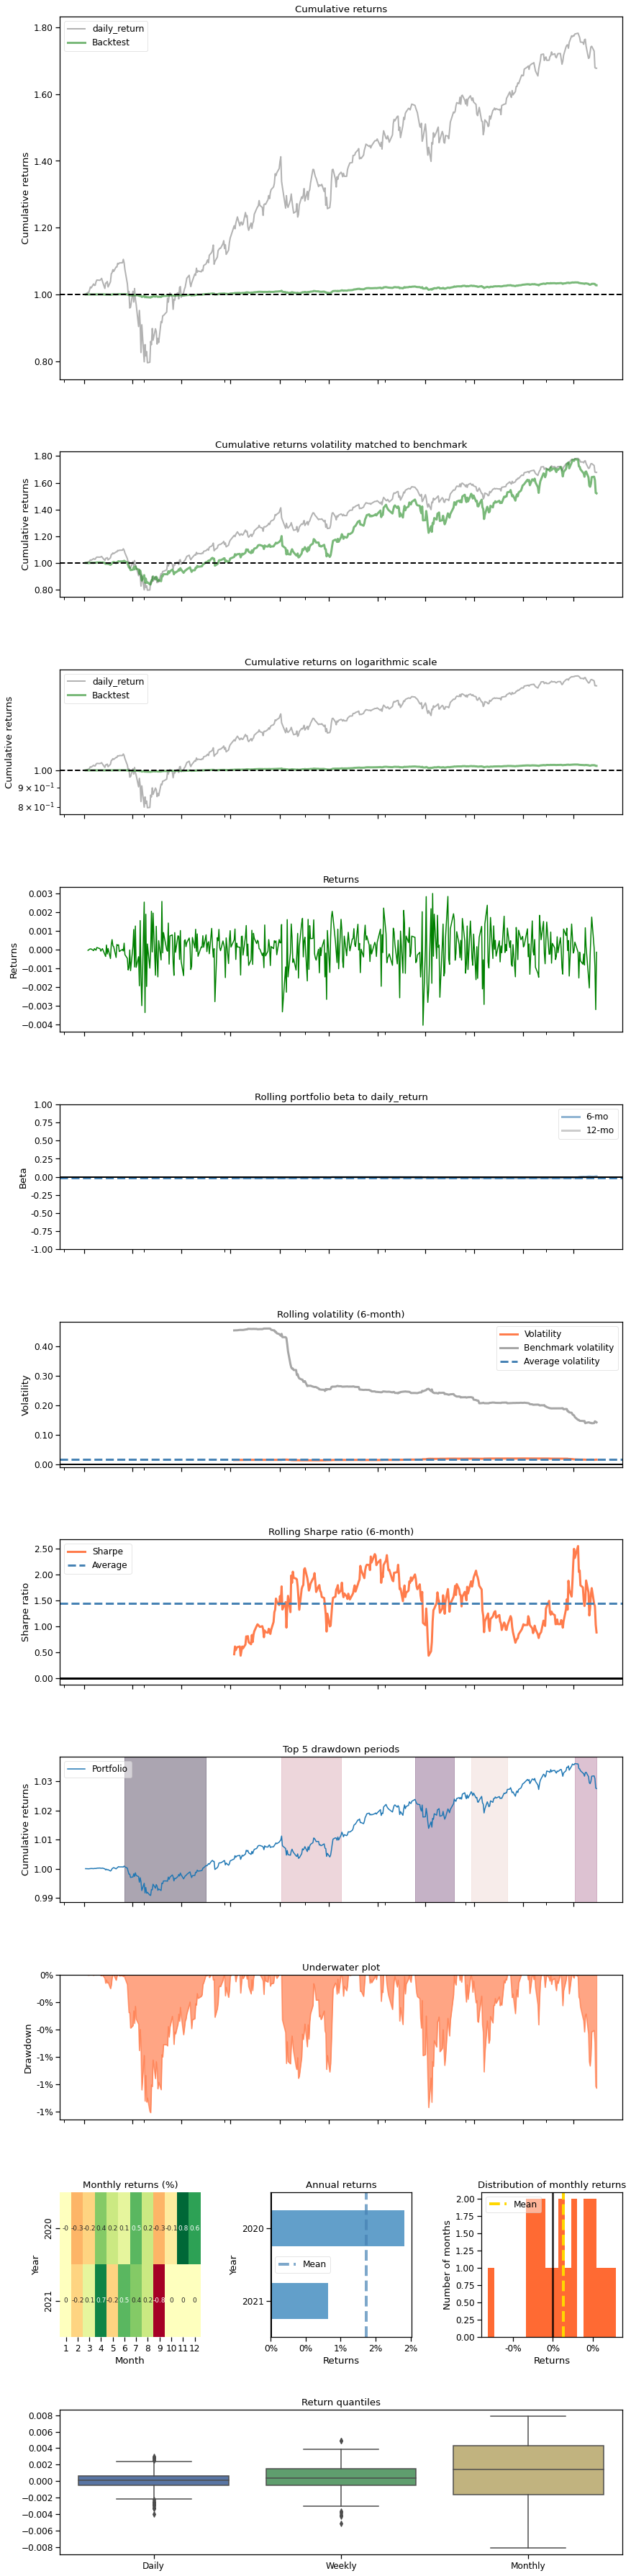

In [ ]:
# Model 1: A2C (Cash Penalty Env)
print("==========Compare A2C To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_a2c, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_a2c.loc[0,'date'],
              baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'], 
              value_col_name = 'total_assets')

==========Compare PPO To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



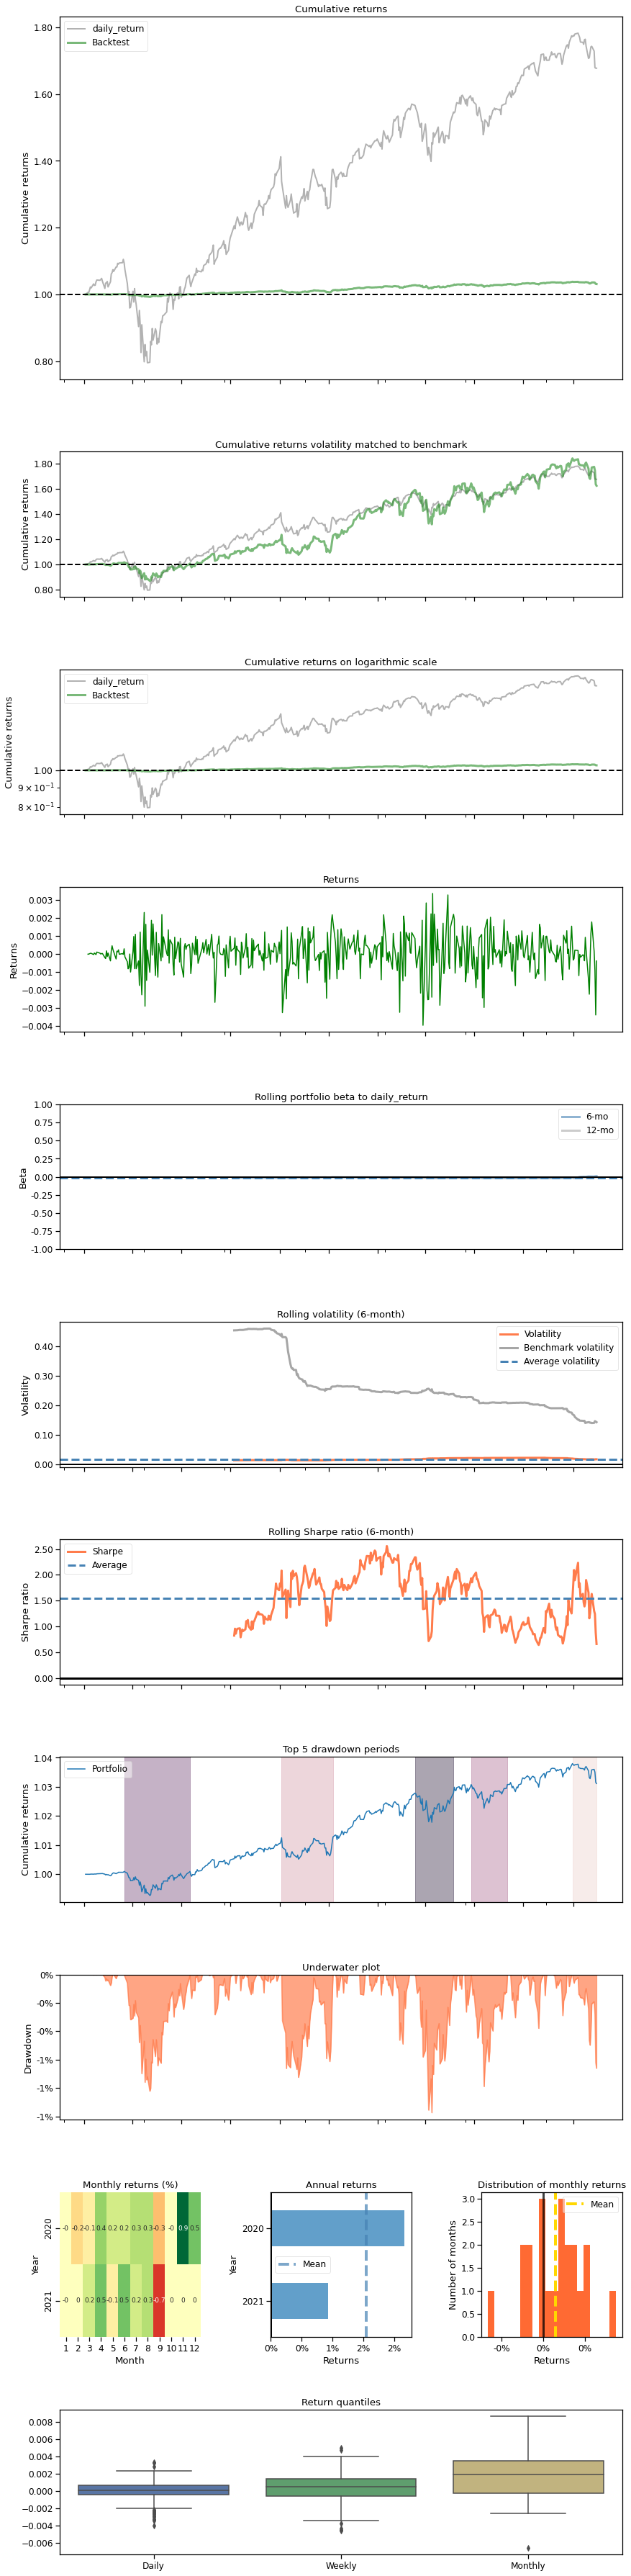

In [ ]:
# Model 2: PPO (Cash Penalty Env)
print("==========Compare PPO To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_ppo, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_ppo.loc[0,'date'],
              baseline_end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'], 
              value_col_name = 'total_assets')

==========Compare DDPG To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



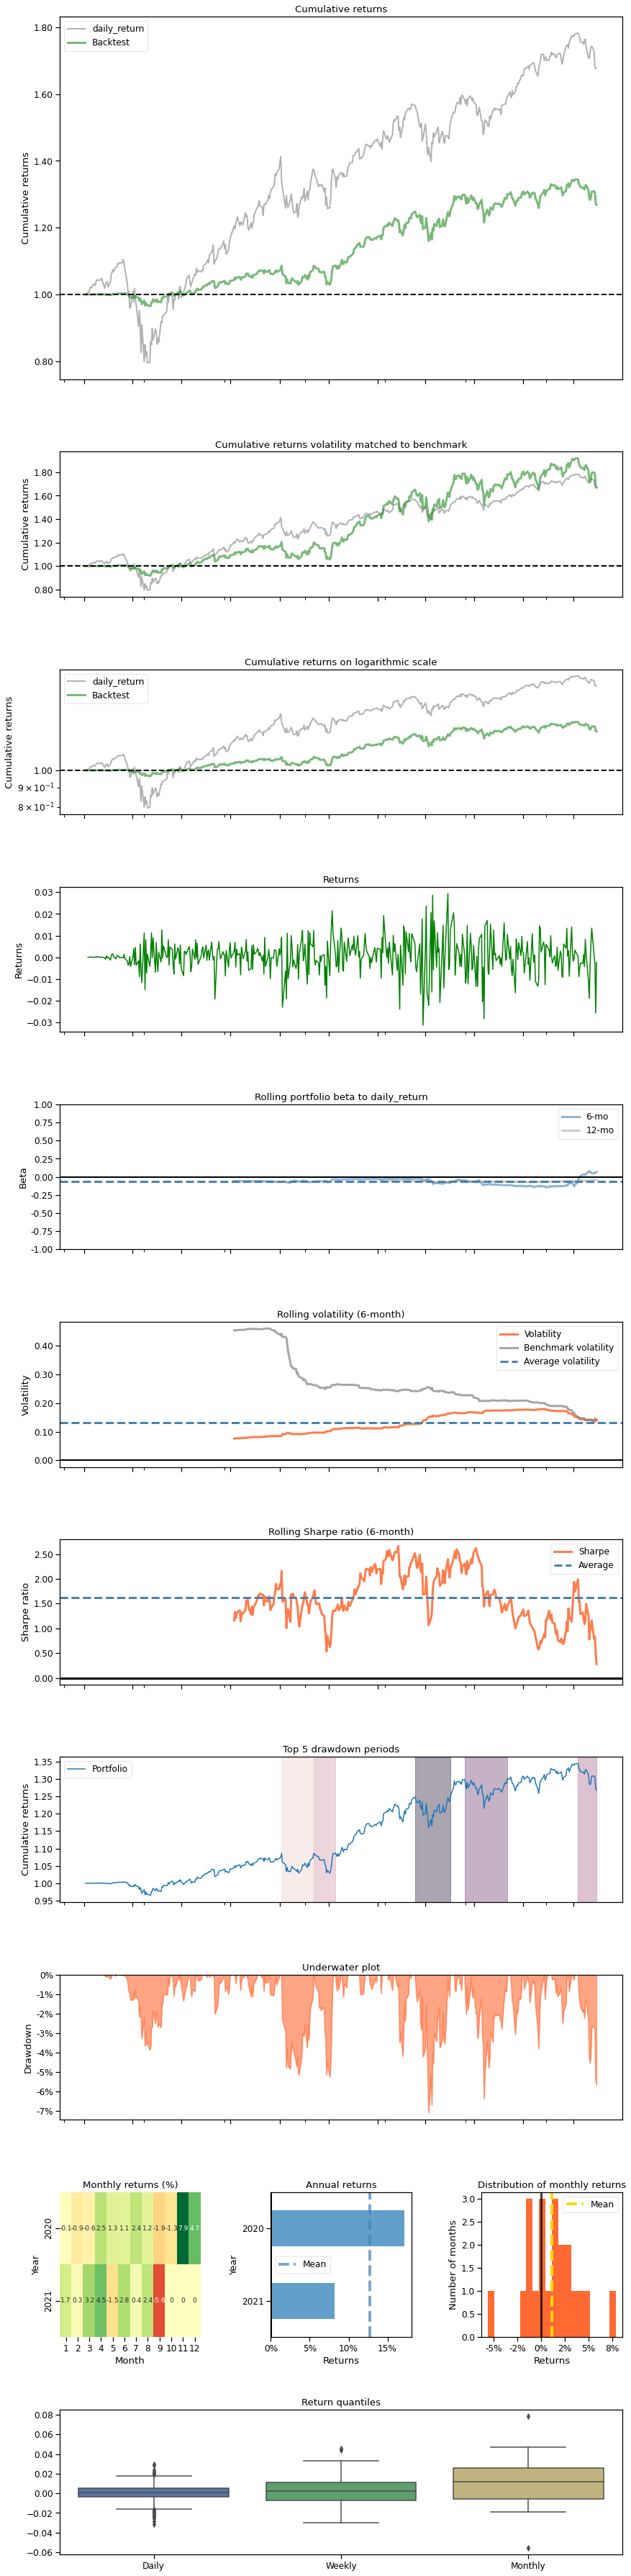

In [ ]:
# Model 3: DDPG (Cash Penalty Env)
print("==========Compare DDPG To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_ddpg, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_ddpg.loc[0,'date'],
              baseline_end = df_account_value_ddpg.loc[len(df_account_value_ddpg)-1,'date'],
              value_col_name = 'total_assets')

==========Compare TD3 To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



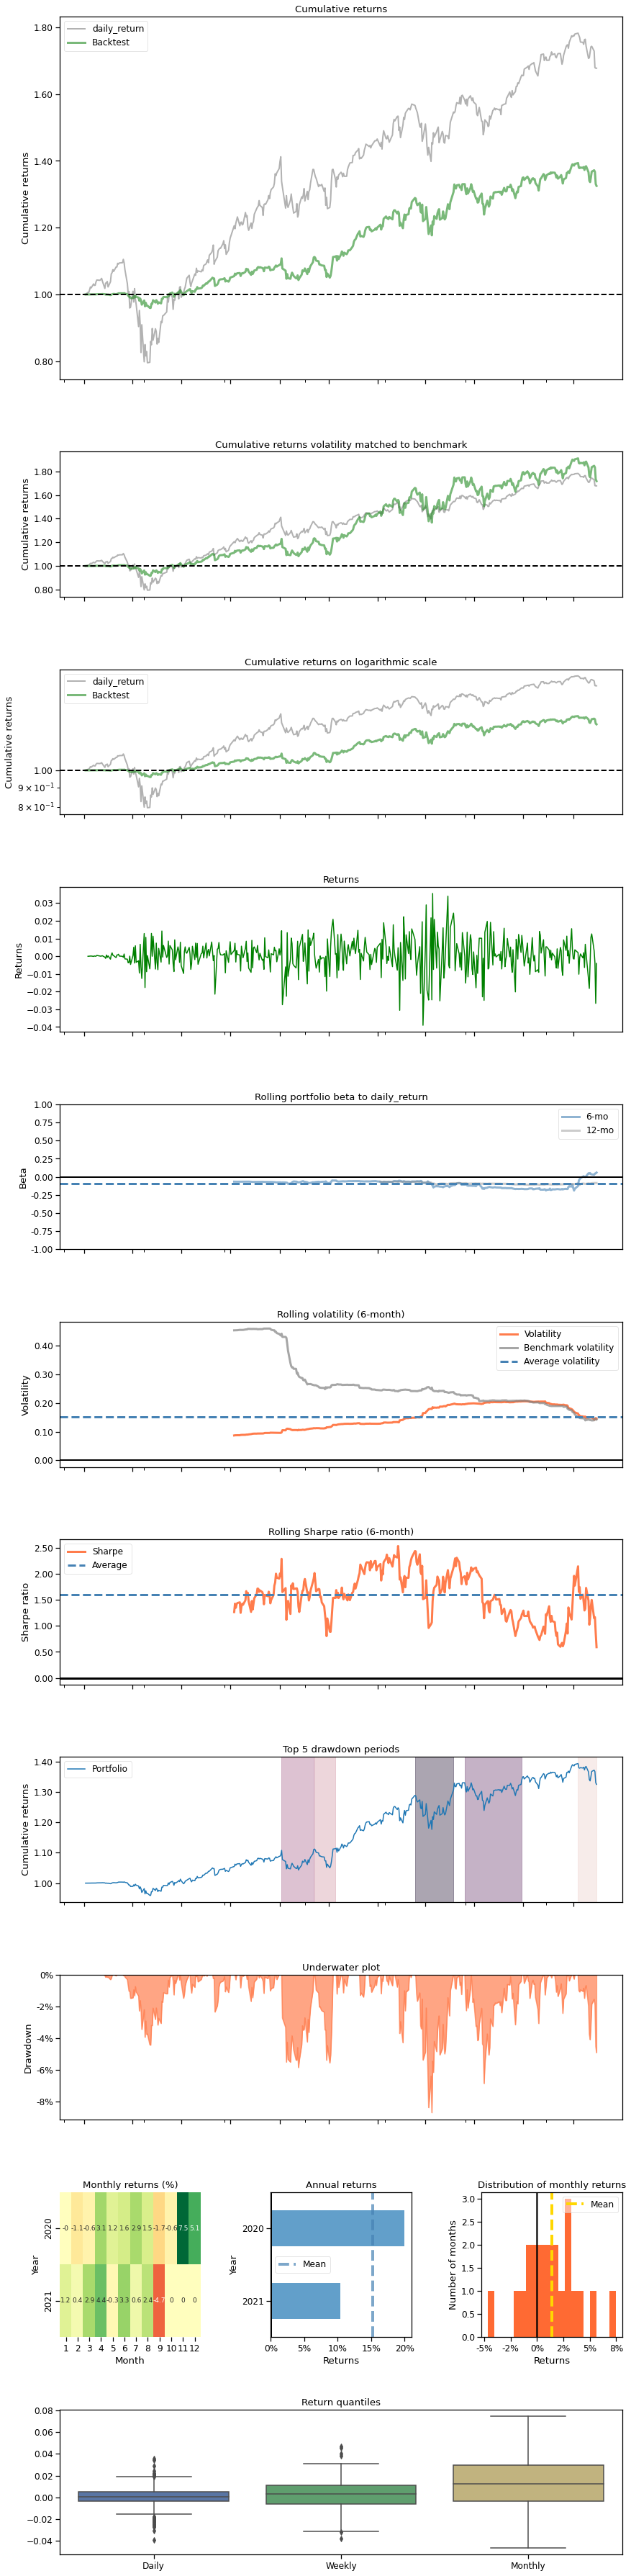

In [ ]:
# Model 4: TD3 (Cash Penalty Env)
print("==========Compare TD3 To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_td3, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_td3.loc[0,'date'],
              baseline_end = df_account_value_td3.loc[len(df_account_value_td3)-1,'date'], 
              value_col_name = 'total_assets')

==========Compare SAC To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



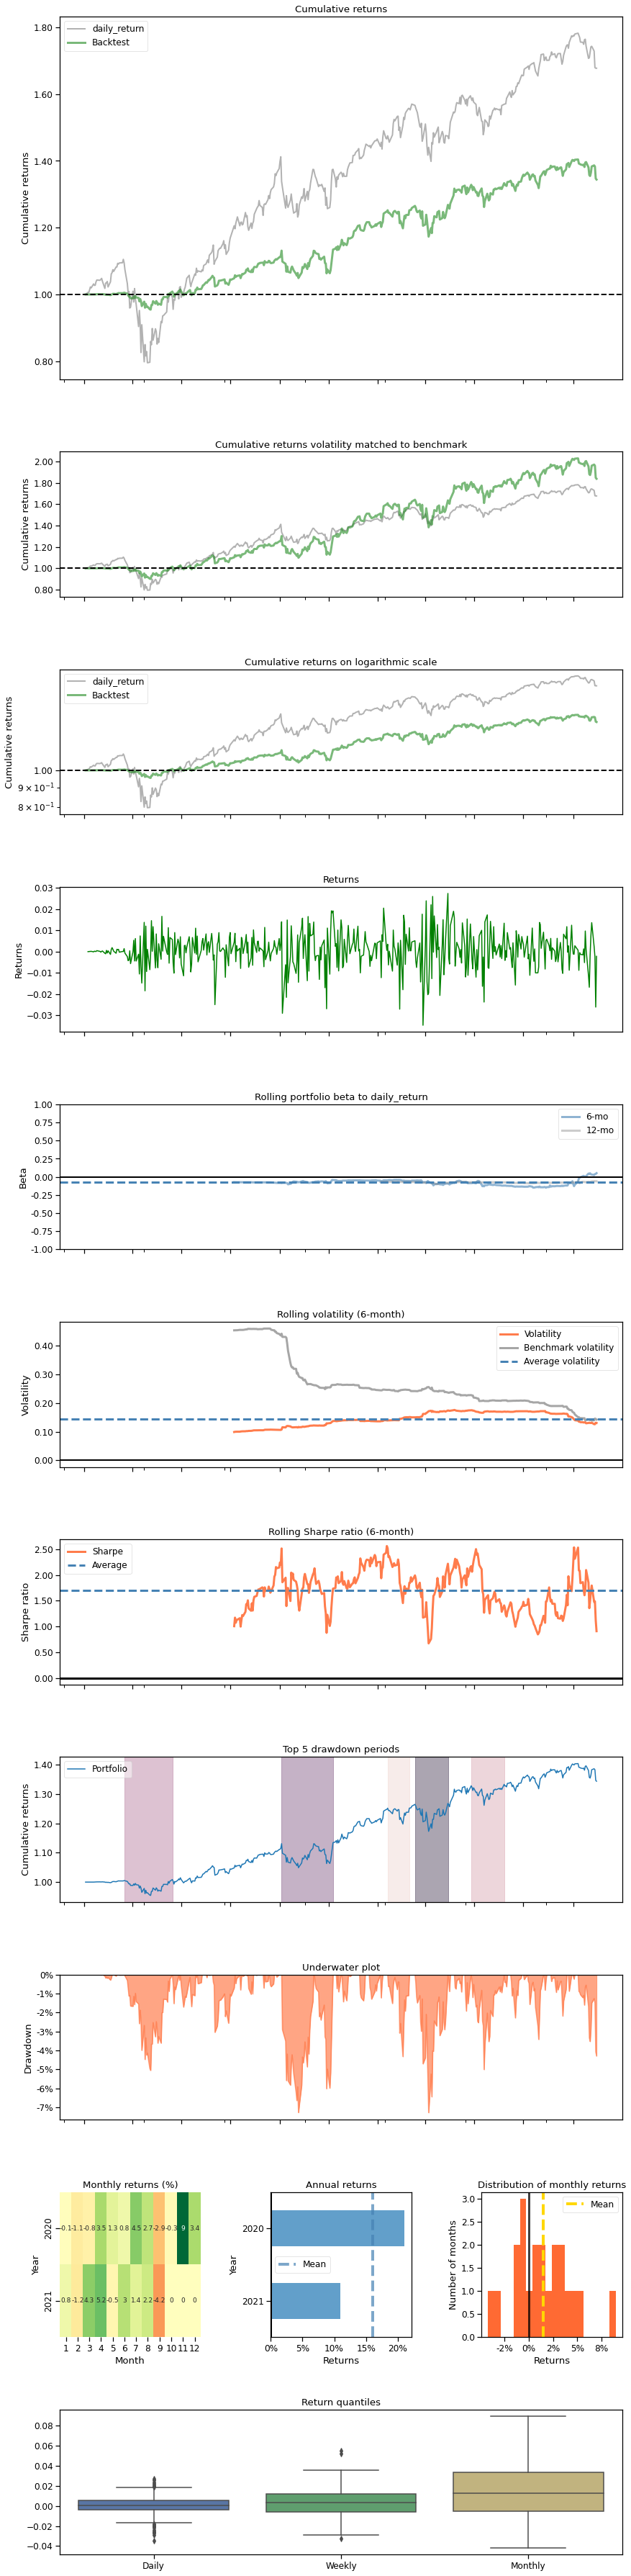

In [ ]:
# Model 5: SAC (Cash Penalty Env)
print("==========Compare SAC To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_sac, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_sac.loc[0,'date'],
              baseline_end = df_account_value_sac.loc[len(df_account_value_sac)-1,'date'], 
              value_col_name = 'total_assets')